In [1]:
pip install itkwidgets


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nilearn


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow-gpu


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install nibabel


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install opencv-python


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


**Setting up the environment**

**Installing the dependencies**

In [6]:
import numpy as np
import nibabel as nib                                                     
import itk                                                                
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate

%matplotlib inline
import seaborn as sns

In [7]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [8]:
image_path = r"C:/Users/Computing/Desktop/archive/BraTS2021_Training_Data/BraTS2021_00005/BraTS2021_00005_flair.nii.gz"
image_obj = nib.load(image_path)
type(image_obj)

nibabel.nifti1.Nifti1Image

In [9]:
image_data = image_obj.get_fdata()
print(type(image_data))
image_data.shape

<class 'numpy.ndarray'>


(240, 240, 155)

In [10]:
def visualize_3d(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap='gray');
    plt.axis('off')
    return layer

interact(visualize_3d, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [11]:
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3. 
}

def visualize_3d_labels(layer):
    mask = nib.load(r"C:/Users/Computing/Desktop/archive/BraTS2021_Training_Data/BraTS2021_00005/BraTS2021_00005_seg.nii.gz").get_fdata()
    plt.imshow(mask[:,:,layer])
    plt.axis('off')
    plt.tight_layout()

interact(visualize_3d_labels, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [12]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 128
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [13]:
TRAIN_DATASET_PATH = r"C:/Users/Computing/Desktop/archive/BraTS2021_Training_Data/"

In [14]:
import os
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_00005')
nSample

['BraTS2021_00005_flair.nii.gz',
 'BraTS2021_00005_seg.nii.gz',
 'BraTS2021_00005_t1.nii.gz',
 'BraTS2021_00005_t1ce.nii.gz',
 'BraTS2021_00005_t2.nii.gz']

In [15]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00005/BraTS2021_00005_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00005/BraTS2021_00005_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00005/BraTS2021_00005_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00005/BraTS2021_00005_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00005/BraTS2021_00005_seg.nii.gz').get_fdata()

Text(0.5, 1.0, 'Mask')

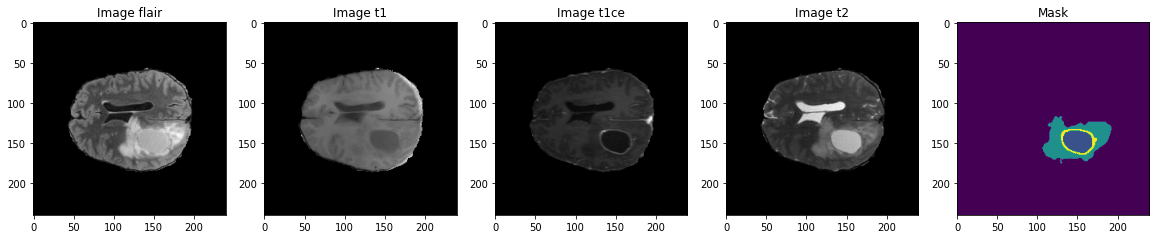

In [16]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

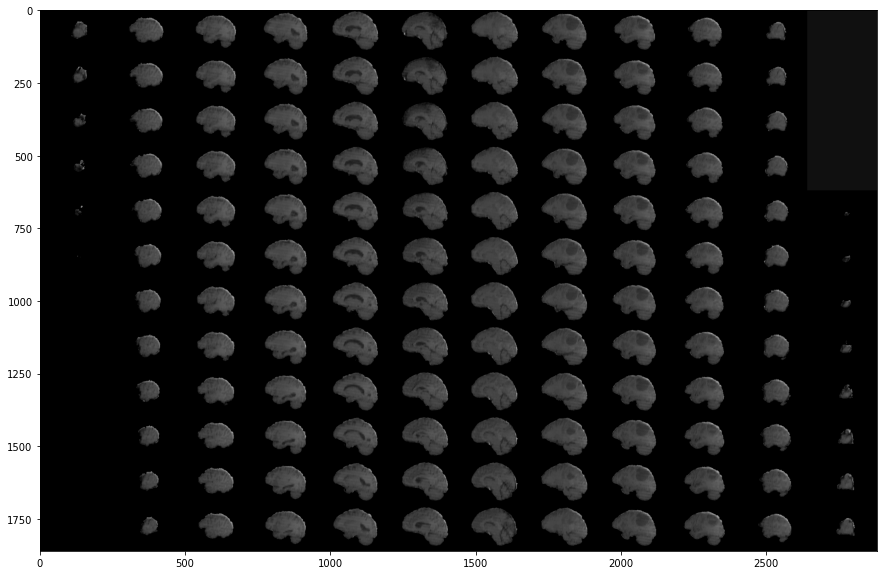

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

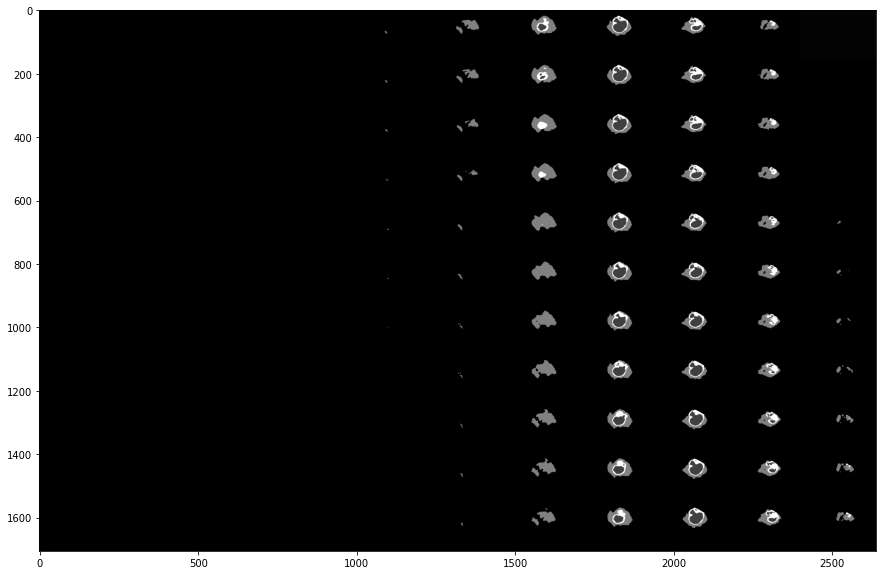

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [19]:
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

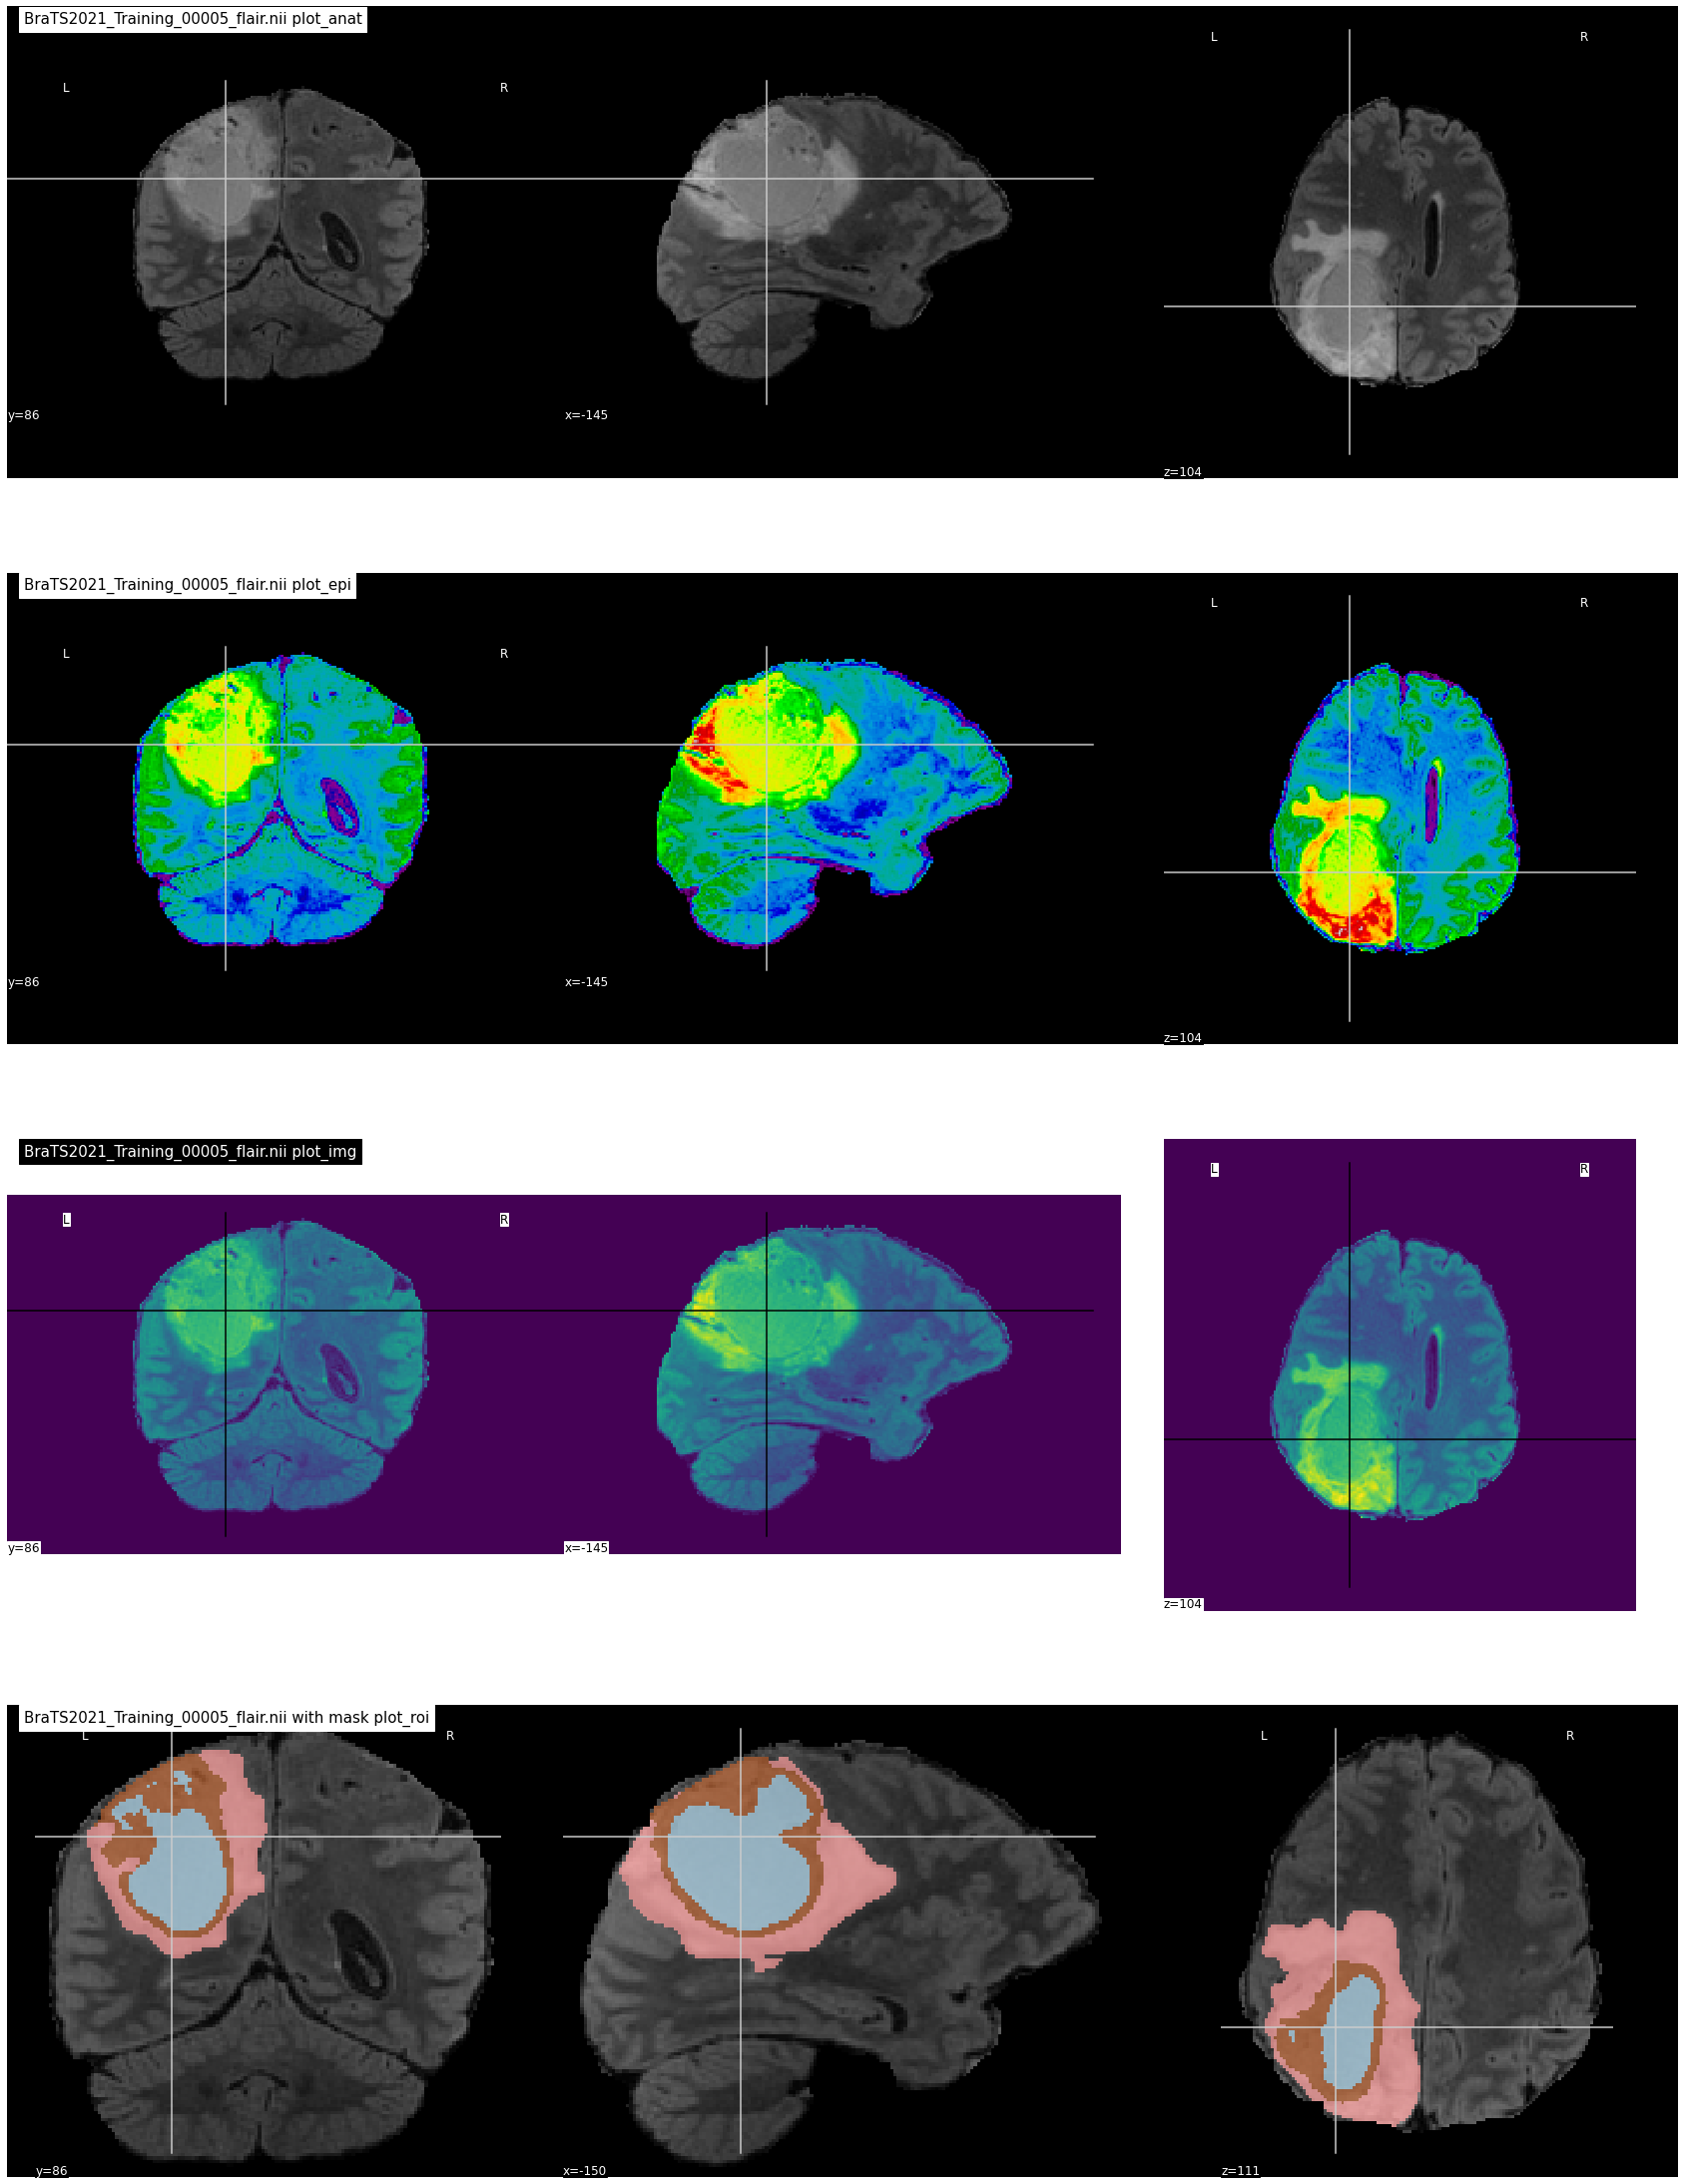

In [20]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_00005/BraTS2021_00005_flair.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_00005/BraTS2021_00005_seg.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS2021_Training_00005_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS2021_Training_00005_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS2021_Training_00005_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS2021_Training_00005_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [21]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [22]:
IMG_SIZE=128

In [23]:
TRAIN_DATASET_PATH = 'C:/Users/Computing/Desktop/archive/BraTS2021_Training_Data/'

In [84]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
    
  X = add([input_mat,X]);
  
  return X

def Unet_3d(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

    #Contraction path
    c1 = Conv3D(n_filters, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(input_img)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(n_filters, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(n_filters*4, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(n_filters*4, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(n_filters*8, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(n_filters*8, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(n_filters*16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(n_filters*16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(n_filters*8, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(n_filters*8, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(n_filters*8, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(n_filters*4, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(n_filters*4, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(n_filters*4, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(n_filters*2, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(n_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(n_filters, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(n_filters, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=input_img, outputs=outputs)

    return model

In [85]:
kernel_initializer =  'he_uniform'

In [86]:
input_layer = Input((128,IMG_SIZE, IMG_SIZE, 2))

model1 = Unet_3d(input_layer)
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                                dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, 
                                                                                                                dice_coef_edema ,dice_coef_enhancing] )

model1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 2)]                                                           
                                                                                                  
 conv3d_95 (Conv3D)             (None, 128, 128, 12  440         ['input_6[0][0]']                
                                8, 8)                                                             
                                                                                                  
 dropout_45 (Dropout)           (None, 128, 128, 12  0           ['conv3d_95[0][0]']              
                                8, 8)                                                       

In [87]:
import os
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

In [88]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [89]:
train_and_test_ids[0] 

'BraTS2021_00000'

In [90]:
train_ids[0]

'BraTS2021_00759'

In [91]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
             X[j+(VOLUME_SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
             
             
             y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        X = X.reshape(1,128,128,128,2)
        y = y.reshape(1,128,128,128)
        # Generate masks
        y[y==4] = 3;
        y = tf.one_hot(y, 4);
        #Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        #Y = np.array(Y).reshape(1,128,128,128)
        return X/np.max(X), y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [92]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

850
251
150


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


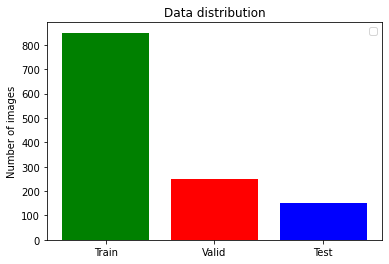

In [93]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2021.png')
    plt.show()
    
showDataLayout()

In [94]:
csv_logger = CSVLogger('C:/Users/Computing/Desktop/archive/training.log', separator=',', append=False)


callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=8, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=8, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'C:/Users/Computing/Desktop/archive/3D-UNet-2021model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),
      csv_logger
    ]

In [96]:
history =  model1.fit(training_generator,
                     epochs=100,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  
model1.save("C:/Users/Computing/Desktop/archive/model_3dUnet_8layer_2mod.h5")

Epoch 1/100
850/850 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9871 - mean_io_u_5: 0.7531 - dice_coef: 0.3108 - precision: 0.9871 - sensitivity: 0.9870 - specificity: 0.9957 - dice_coef_necrotic: 0.0671 - dice_coef_edema: 0.1370 - dice_coef_enhancing: 0.0452
Epoch 1: val_loss improved from inf to 0.04863, saving model to C:/Users/Computing/Desktop/archive\3D-UNet-2021model_.01-0.048626.m5
850/850 [==============================] - 295s 347ms/step - loss: 0.0569 - accuracy: 0.9871 - mean_io_u_5: 0.7531 - dice_coef: 0.3108 - precision: 0.9871 - sensitivity: 0.9870 - specificity: 0.9957 - dice_coef_necrotic: 0.0671 - dice_coef_edema: 0.1370 - dice_coef_enhancing: 0.0452 - val_loss: 0.0486 - val_accuracy: 0.9868 - val_mean_io_u_5: 0.7367 - val_dice_coef: 0.3396 - val_precision: 0.9875 - val_sensitivity: 0.9864 - val_specificity: 0.9959 - val_dice_coef_necrotic: 0.0943 - val_dice_coef_edema: 0.1791 - val_dice_coef_enhancing: 0.0901 - lr: 0.0010
Epoch 2/100
850/8

In [104]:
print("Evaluate on test data")
results = model1.evaluate(test_generator, callbacks= callbacks)
print("test loss, test acc:", results)


Evaluate on test data
150/150 [==============================] - 37s 246ms/step - loss: 0.0160 - accuracy: 0.9948 - mean_io_u_5: 0.8694 - dice_coef: 0.7315 - precision: 0.9960 - sensitivity: 0.9940 - specificity: 0.9987 - dice_coef_necrotic: 0.4813 - dice_coef_edema: 0.7333 - dice_coef_enhancing: 0.7124
test loss, test acc: [0.015970751643180847, 0.9948136210441589, 0.8694289922714233, 0.7314507365226746, 0.9959919452667236, 0.99396151304245, 0.9986681342124939, 0.48131272196769714, 0.7333204746246338, 0.7123534083366394]


In [98]:
print("Evaluate on val data")
results = model1.evaluate(valid_generator, callbacks= callbacks)
print("val loss, val acc:", results)

Evaluate on val data
251/251 [==============================] - 62s 247ms/step - loss: 0.0142 - accuracy: 0.9954 - mean_io_u_5: 0.8713 - dice_coef: 0.7569 - precision: 0.9965 - sensitivity: 0.9946 - specificity: 0.9988 - dice_coef_necrotic: 0.5035 - dice_coef_edema: 0.7607 - dice_coef_enhancing: 0.7645
val loss, val acc: [0.01416836865246296, 0.9953837394714355, 0.8712506294250488, 0.7569038271903992, 0.9964852333068848, 0.9945586323738098, 0.9988313317298889, 0.5034840106964111, 0.760688841342926, 0.7644568681716919]


In [377]:
model = tf.keras.models.load_model('C:/Users/Computing/Desktop/archive/model_3dUnet_8layer_2mod.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

In [378]:
import pandas as pd
history = pd.read_csv(r'C:/Users/Computing/Desktop/archive/training.log', sep=',', engine='python')

hist=history

In [379]:
# Reports the AUC of a model outputting a probability.
model.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

# Reports the AUC of a model outputting a logit.
model.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])


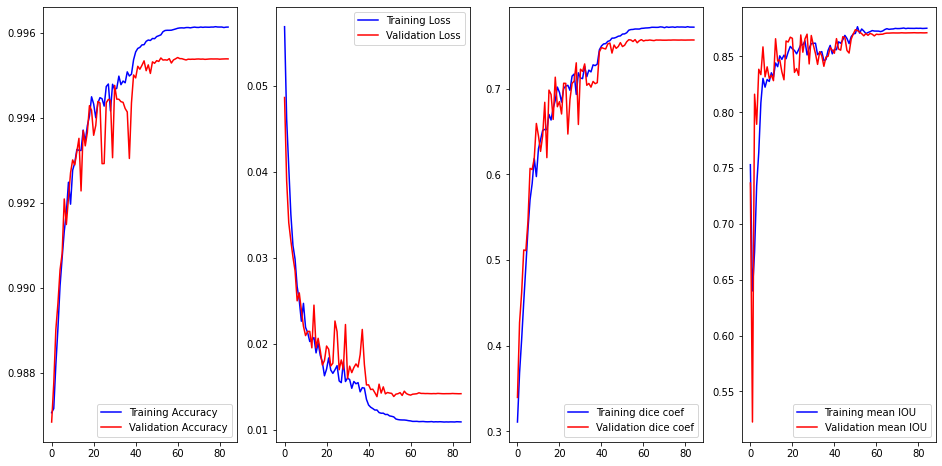

In [380]:
# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_5'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_5'],'r',label='Validation mean IOU')
ax[3].legend()


plt.savefig('training_result_2021.png')
plt.show()